In [30]:
import theano
from theano import tensor as T
from theano.tensor.nnet import conv2d
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.signal import downsample
import numpy
import numpy as np
import time
import pylab
from PIL import Image
from Data import Load
import csv
import os
import pickle
import sys
from sklearn.utils import shuffle

from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d

################################################################################
# Global utilities and functions
################################################################################
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def dropout(X, p=0.):
    if p > 0:
        X *= srng.binomial(X.shape, p=1 - p, dtype=theano.config.floatX)
        X /= 1 - p
    return X

def backprop(cost, w, alpha=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        
        # adding gradient scaling
        acc = theano.shared(w1.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * grad ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        grad = grad / gradient_scaling
        updates.append((acc, acc_new))
        
        updates.append((w1, w1 - grad * alpha))
    return updates

################################################################################
## (1) Convolutional Network Parameters
################################################################################
numClasses = 30
numHiddenNodes = 1000 
patchWidth = 3
patchHeight = 3
featureMapsLayer1 = 32
featureMapsLayer2 = 64
featureMapsLayer3 = 128

# Regularization parameter for the fully connected NN
lambda_reg = .00001

# For convonets, we will work in 2d rather than 1d.  The dataset images are 96 * 96
imageWidth = 96

# Convolution layers.  
w_1 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer1, 1, patchWidth, patchHeight))*.01))))
w_2 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer2, featureMapsLayer1, patchWidth, patchHeight))*.01))))
w_3 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer3, featureMapsLayer2, patchWidth, patchHeight))*.01))))

# Fully connected NN. 
w_4 = theano.shared(floatX(np.asarray((np.random.randn(*(featureMapsLayer3 * 10 * 10, numHiddenNodes))*.01))))
w_5 = theano.shared(floatX(np.asarray((np.random.randn(*(numHiddenNodes, numHiddenNodes))*.01))))
w_6 = theano.shared(floatX(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*.01))))

# Bias values
b_1 = theano.shared(value=numpy.zeros((featureMapsLayer1,), dtype=theano.config.floatX), borrow=True)
b_2 = theano.shared(value=numpy.zeros((featureMapsLayer2,), dtype=theano.config.floatX), borrow=True)
b_3 = theano.shared(value=numpy.zeros((featureMapsLayer3,), dtype=theano.config.floatX), borrow=True)

params = [w_1, w_2, w_3, w_4, w_5, w_6, b_1, b_2, b_3]

## (2) Model
X = T.matrix('X').reshape((-1, 1, 96, 96)) # conv2d works with tensor4 type
Y = T.matrix('Y')


# Theano provides built-in support for add convolutional layers
def convolutional_model(X, w_1, w_2, w_3, w_4, w_5, w_6, p_1, p_2, p_3, p_4, p_5):
    l1 = dropout(T.tanh( max_pool_2d(T.maximum(conv2d(X, w_1, border_mode='full'),0.), (2, 2),ignore_border=True) + b_1.dimshuffle('x', 0, 'x', 'x') ), p_1)
    l2 = dropout(T.tanh( max_pool_2d(T.maximum(conv2d(l1, w_2), 0.), (2, 2),ignore_border=True) + b_2.dimshuffle('x', 0, 'x', 'x') ), p_2)
    l3 = dropout(T.flatten(T.tanh( max_pool_2d(T.maximum(conv2d(l2, w_3), 0.), (2, 2),ignore_border=True) + b_3.dimshuffle('x', 0, 'x', 'x') ), outdim=2), p_3)# flatten to switch back to 1d layers
    l4 = dropout(T.maximum(T.dot(l3, w_4), 0.), p_4)
    l5 = dropout(T.maximum(T.dot(l4, w_5), 0.), p_5)
    return T.dot(l5, w_6)

y_hat_train = convolutional_model(X, w_1, w_2, w_3, w_4, w_5, w_6, 0.1, 0.2, 0.3, 0.5, 0.5)
y_hat_predict = convolutional_model(X, w_1, w_2, w_3, w_4, w_5, w_6, 0., 0., 0., 0., 0.)

## (3) Regularized Cost
cost = ((Y - (y_hat_predict))**2).mean() + lambda_reg*((w_4**2).sum() + (w_5**2).sum() + (w_6**2).sum())

## (4) Minimization.  
update = backprop(cost, params)
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
y_pred = y_hat_predict
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

###############################################################################
# One Hidden layer NN to process convo prediction output
###############################################################################
back_num_inputs = 30
back_num_hidden = 30
back_num_outputs = 1
back_pdrop_input = .2
back_pdrop_hidden = .2

class TwoHiddenLayerNN:
    def __init__(self, inputs, hidden, outputs, pdrop_input, pdrop_hidden, weight_initialization_index=None):
        self.num_inputs = inputs
        self.num_hidden = hidden
        self.num_outputs = outputs
        
        if weight_initialization_index is None:
            # By deafult initialize random weights
            self.w_h_1 = theano.shared(floatX(np.asarray((np.random.randn(*(self.num_inputs, self.num_hidden))*.01))))
            self.w_h_2 = theano.shared(floatX(np.asarray((np.random.randn(*(self.num_hidden, self.num_hidden))*.01))))
            self.w_o = theano.shared(floatX(np.asarray((np.random.randn(*(self.num_hidden, self.num_outputs))*.01))))
        else:
            # All weigths are zero except the input value we want to start gradient descent from
            w_h_1 = numpy.zeros((self.num_inputs, self.num_hidden), dtype=theano.config.floatX)
            w_h_1[weight_initialization_index,weight_initialization_index] = 1.0
            w_h_2 = numpy.zeros((self.num_hidden, self.num_hidden), dtype=theano.config.floatX)
            w_h_2[weight_initialization_index,weight_initialization_index] = 1.0
            w_o = numpy.zeros((self.num_hidden, self.num_outputs), dtype=theano.config.floatX)
            w_o[weight_initialization_index,0] = 1.0
            
            self.w_h_1 = theano.shared(value=w_h_1, borrow=True)
            self.w_h_2 = theano.shared(value=w_h_2, borrow=True)
            self.w_o = theano.shared(value=w_o, borrow=True)

        self.X = T.fmatrix("back_X")
        self.Y = T.fmatrix("back_Y")

        training_activation_layer2, self.training_prediction = self.model(pdrop_input, pdrop_hidden)
        pred_activation_layer2, self.actual_prediction = self.model(0., 0.)
        
        self.training_cost = ((self.Y - self.training_prediction)**2).mean()
        
        self.params = [self.w_h_1, self.w_h_2, self.w_o]
        self.updates = self.sgd()
        
        self.train = theano.function(inputs=[self.X, self.Y], outputs=self.training_cost, updates=self.updates, allow_input_downcast=True)
        self.predict = theano.function(inputs=[self.X], outputs=self.actual_prediction, allow_input_downcast=True)

    def train(self, X, Y):
        return self.train(X, Y)
    
    def predict(self, X):
        return self.predict(X)
    
    def backprop(self, alpha=0.001, rho=0.9, epsilon=1e-6):
        grads = T.grad(cost=self.training_cost, wrt=self.params)
        updates = []
        for w1, grad in zip(self.params, grads):

            # adding gradient scaling
            acc = theano.shared(w1.get_value() * 0.)
            acc_new = rho * acc + (1 - rho) * grad ** 2
            gradient_scaling = T.sqrt(acc_new + epsilon)
            grad = grad / gradient_scaling
            updates.append((acc, acc_new))

            updates.append((w1, w1 - grad * alpha))
        return updates


    def model(self, pdrop_input, pdrop_hidden):
        #X = dropout(self.X, pdrop_input)

        #h1 = T.maximum(T.dot(self.X, self.w_h_1), 0.)
        #h1 = dropout(h1, pdrop_hidden)
        h1 = T.dot(self.X, self.w_h_1)
        #h1 = dropout(h1, pdrop_hidden)
        
        #h2 = T.maximum(T.dot(h1, self.w_h_2), 0.)
        #h2 = dropout(h2, pdrop_hidden)
        h2 = T.dot(h1, self.w_h_2)

        py_x = T.dot(h2, self.w_o)
        return h2, py_x

    def sgd(self, lr=0.001):
        grads = T.grad(cost=self.training_cost, wrt=self.params)
        updates = []
        for w1, grad in zip(self.params, grads):
            updates.append([w1, w1 - grad * lr])
        return updates
    
    def gradient_descent_stochastic(self, trX, trY, deX, deY, epochs, miniBatchSize=1):
        training_costs=[]
        dev_costs=[]
        trainTime = 0.0
        predictTime = 0.0
        start_time = time.time()
        for i in range(epochs):       
            for start, end in zip(range(0, len(trX), miniBatchSize), range(miniBatchSize, len(trX), miniBatchSize)):
                cost = self.train(trX[start:end], trY[start:end])

            # Compute overall dev and training costs after epoch
            pdeY = self.predict(deX)
            cost_de = ((deY - pdeY)**2).mean()

            ptrY = self.predict(trX)
            cost_tr = ((trY - ptrY)**2).mean()

            # Capture the traning and dev costs on each epoch
            training_costs.append(cost_tr)
            dev_costs.append(cost_de)

            print '%d) Back Traning cost=%.8f, DE cost: %.8f' %(i+1, cost_tr, cost_de)
            trainTime =  trainTime + (time.time() - start_time)
   
        print 'train time = %.2f' %(trainTime)

        return training_costs, dev_costs

################################################################################
# Model Execution
################################################################################

all_X, all_Y = Load.load()

test_indices = np.random.choice(all_X.shape[0], .2*all_X.shape[0], replace=False)
keep = np.ones(all_X.shape[0], dtype=bool) # array of True matching 1st dim
keep[test_indices] = False
trX = all_X[keep,:]
trY = all_Y[keep,:]
deX = all_X[test_indices]
deY = all_Y[test_indices]

rot_X, rot_Y = Load.rotate_images(trX, trY)
blur_X, blur_Y = Load.blurr_images(trX, trY)
trans_X, trans_Y = Load.transpose_images(trX, trY)

trX, trY = np.vstack((trX, rot_X)), np.vstack((trY, rot_Y))
trX, trY = np.vstack((trX, blur_X)), np.vstack((trY, blur_Y))
trX, trY = np.vstack((trX, trans_X)), np.vstack((trY, trans_Y))

trX, trY = shuffle(trX, trY, random_state=42)  # shuffle data
rot_X, rot_Y, blur_X, blur_Y, tr_X, tr_Y = None, None, None, None, None, None

trX = trX.reshape(-1, 1, imageWidth, imageWidth)
deX = deX.reshape(-1, 1, imageWidth, imageWidth)

miniBatchSize = 1
def convolutional_gradientDescentStochastic(epochs):
    training_costs=[]
    dev_costs=[]
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    for i in range(epochs):       
        for start, end in zip(range(0, len(trX), miniBatchSize), range(miniBatchSize, len(trX), miniBatchSize)):
            cost = train(trX[start:end], trY[start:end])
        
        # Compute overall dev and training costs after epoch
        pdeY = predict(deX)
        cost_de = ((deY - pdeY)**2).mean()
        
        ptrY = predict(trX)
        cost_tr = ((trY - ptrY)**2).mean()
        
        # Capture the traning and dev costs on each epoch
        training_costs.append(cost_tr)
        dev_costs.append(cost_de)
        
        print '%d) Convo precision=%.8f, Traning cost=%.8f, DE cost: %.8f' %(i+1, np.mean(np.allclose(deY, pdeY)), cost_tr, cost_de)
        trainTime =  trainTime + (time.time() - start_time)
    print 'train time = %.2f' %(trainTime)
    
    return training_costs, dev_costs, ptrY, pdeY

convo_training_costs, convo_dev_costs,  convo_training_preds, convo_dev_preds = convolutional_gradientDescentStochastic(100)



ImportError: No module named pylearn2.sandbox.cuda_convnet.stochastic_pool

In [21]:
#
# Post convolution NNs
#

de_post_predictions = np.zeros((deY.shape[0],deY.shape[1]), dtype=theano.config.floatX)
tr_post_predictions = np.zeros((trY.shape[0],trY.shape[1]), dtype=theano.config.floatX)
post_NNs = []

for i in range(0,30):
    hiddenNN = TwoHiddenLayerNN(back_num_inputs, back_num_hidden, back_num_outputs, 
                                back_pdrop_input, back_pdrop_hidden, i)
    hiddenNN.gradient_descent_stochastic(convo_training_preds, trY[:,[i]], convo_dev_preds, deY[:,[i]], 200)
    post_NNs.append(hiddenNN)
    
    pred_deY = hiddenNN.predict(convo_dev_preds)
    pred_trY = hiddenNN.predict(convo_training_preds)
    
    de_post_predictions[:,[i]] = pred_deY
    tr_post_predictions[:,[i]] = pred_trY

print 'Mean Dev squared error on Post Predictions: %.8f\n'%((deY - de_post_predictions)**2).mean()
print 'Mean Training squared error on Post Predictions: %.8f\n'%((trY - tr_post_predictions)**2).mean()

print 'Mean squared error on Training data: %.8f\n'%((trY - trY.mean())**2).mean()
print 'Mean squared error on Dev data: %.8f\n'%((deY - deY.mean())**2).mean()

1) Back Traning cost=0.00019346, DE cost: 0.00045116
2) Back Traning cost=0.00019231, DE cost: 0.00045015
3) Back Traning cost=0.00019127, DE cost: 0.00044921
4) Back Traning cost=0.00019032, DE cost: 0.00044834
5) Back Traning cost=0.00018945, DE cost: 0.00044754
6) Back Traning cost=0.00018865, DE cost: 0.00044679
7) Back Traning cost=0.00018792, DE cost: 0.00044610
8) Back Traning cost=0.00018725, DE cost: 0.00044546
9) Back Traning cost=0.00018662, DE cost: 0.00044487
10) Back Traning cost=0.00018605, DE cost: 0.00044433
11) Back Traning cost=0.00018553, DE cost: 0.00044382
12) Back Traning cost=0.00018504, DE cost: 0.00044335
13) Back Traning cost=0.00018460, DE cost: 0.00044292
14) Back Traning cost=0.00018418, DE cost: 0.00044252
15) Back Traning cost=0.00018380, DE cost: 0.00044215
16) Back Traning cost=0.00018345, DE cost: 0.00044180
17) Back Traning cost=0.00018313, DE cost: 0.00044148
18) Back Traning cost=0.00018283, DE cost: 0.00044119
19) Back Traning cost=0.00018255, DE 

In [5]:
# Use best of predictions from both Convo and Post NN as the final prediction
de_mixed_predictions = convo_dev_preds.copy()
tr_mixed_predictions = convo_training_preds.copy()

for i in range(0,30):
    if ((tr_post_predictions[:,[i]]-trY[:,[i]])**2).mean() < ((tr_mixed_predictions[:,[i]]-trY[:,[i]])**2).mean():
        tr_mixed_predictions[:,[i]] = tr_post_predictions[:,[i]]
        de_mixed_predictions[:,[i]] = de_post_predictions[:,[i]]
        
print 'Mean Dev squared error on Convo Predictions: %.8f\n'%((deY - convo_dev_preds)**2).mean()
print 'Mean Training squared error on Convo Predictions: %.8f\n'%((trY - convo_training_preds)**2).mean()

print 'Mean Dev squared error on Mixed Predictions: %.8f\n'%((deY - de_mixed_predictions)**2).mean()
print 'Mean Training squared error on Mixed Predictions: %.8f\n'%((trY - tr_mixed_predictions)**2).mean()

Mean Dev squared error on Convo Predictions: 0.00086365

Mean Training squared error on Convo Predictions: 0.00028392

Mean Dev squared error on Mixed Predictions: 0.00078557

Mean Training squared error on Mixed Predictions: 0.00021144



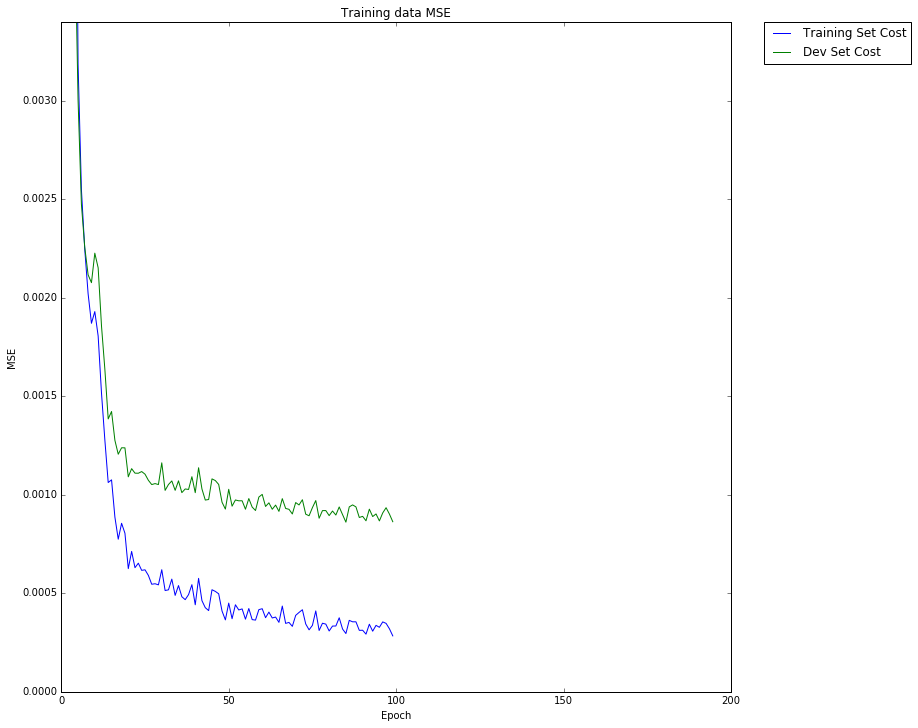

In [31]:
%matplotlib inline
import matplotlib.colors as clrs
import matplotlib.pyplot as plt

# Plot the trainig data costs over time
plt.figure(figsize=(12, 12))
training_plt = plt.plot(convo_training_costs, c='b', label='Training Set Cost')
dev_plt = plt.plot(convo_dev_costs, c='g', label='Dev Set Cost')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Training data MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.axis([0, 200, 0, 0.0034])
plt.show()

In [7]:
def plot_sample(axis, x, y, y_pred=None,):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', c='r', s=10)
    
    if y_pred is not None:
        axis.scatter(y[0::2] * 48 + 48, y_pred[1::2] * 48 + 48, marker='x', s=10)

[327 416 350  54 309 391 219 279 211 223 273   5 342 285  26  15 230 199
  36 284]
[ 0.00731949  0.0068698   0.0065824   0.00643249  0.00589223  0.0053114
  0.00479299  0.00411573  0.00348637  0.00348313  0.00348162  0.00319115
  0.00309483  0.00297543  0.00284011  0.0027521   0.00275198  0.00273224
  0.00264334  0.00245389]


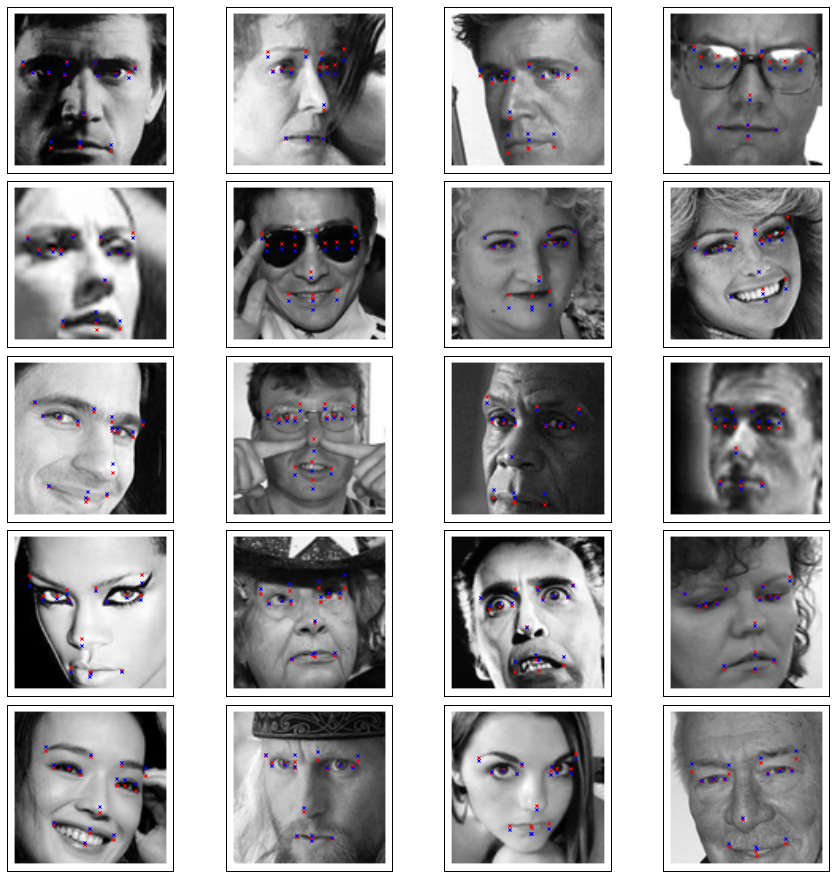

In [11]:
# Find the dev set images with the highest costs
final_pdeY = de_mixed_predictions
final_cost_de = ((deY - final_pdeY)**2).mean(axis=1)
final_ptrY = tr_mixed_predictions
final_cost_tr = ((trY - final_ptrY)**2).mean(axis=1)

# Print the highest dev set indices
highest_dev_indices = np.array(final_cost_de).argsort()[::-1][:20]
print highest_dev_indices

# Print the highest dev costs
highest_dev_costs = final_cost_de.copy()
highest_dev_costs.sort()
print highest_dev_costs[::-1][:20]

# Plot the images with the highest dev costs
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    plot_sample(ax, deX[highest_dev_indices[i]], deY[highest_dev_indices[i]], final_pdeY[highest_dev_indices[i]])

[2212 1971 2310  263   95 2165 1703 1688  685 1568 2514 1499  542 1859 1279
 1628  955 1907  605  798]
[ 0.00272872  0.00246574  0.00182811  0.0017819   0.00166972  0.0016382
  0.00155622  0.00146925  0.00136667  0.00127334  0.00125051  0.00113576
  0.00113512  0.00111176  0.00108926  0.00107118  0.00106986  0.00106545
  0.00105903  0.00105401]


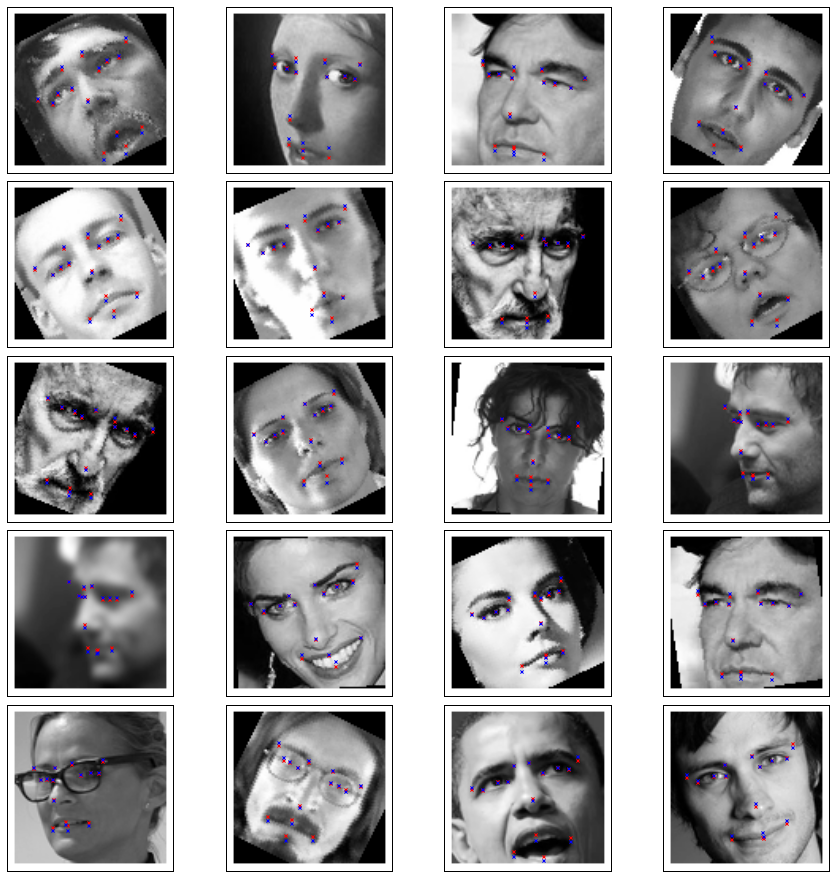

In [12]:
# Print the highest training set indices
highest_tr_indices = np.array(final_cost_tr).argsort()[::-1][:20]
print highest_tr_indices

# Print the highest training costs
highest_tr_costs = final_cost_tr.copy()
highest_tr_costs.sort()
print highest_tr_costs[::-1][:20]

# Plot the images with the highest training costs
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0,20):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    plot_sample(ax, trX[highest_tr_indices[i]], trY[highest_tr_indices[i]], final_ptrY[highest_tr_indices[i]])

('Quartiles: ', array([  9.87341336e-05,   2.77666404e-04,   4.98299865e-04,
         9.02200758e-04]))


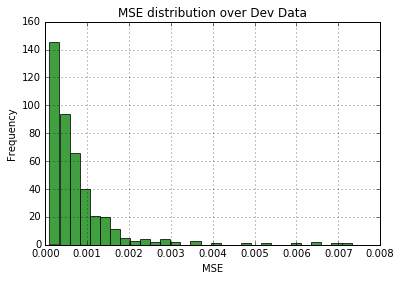

('Quartiles: ', array([  3.93237933e-05,   1.15024090e-04,   1.65190984e-04,
         2.39157016e-04]))


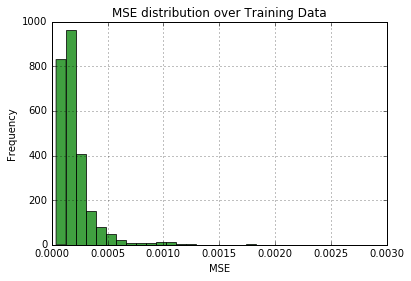

In [13]:
# Let's look into the distribution of the costs on the dev data
print('Quartiles: ', np.percentile(final_cost_de, np.arange(0, 100, 25))) # quartiles
n, bins, patches = plt.hist(final_cost_de, bins=30, facecolor='green', alpha=0.75)

plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('MSE distribution over Dev Data')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

# Let's look at the Training Data ditribution
print('Quartiles: ', np.percentile(final_cost_tr, np.arange(0, 100, 25))) # quartiles
n, bins, patches = plt.hist(final_cost_tr, bins=30, facecolor='green', alpha=0.75)

plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('MSE distribution over Training Data')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

(30,)
[ 0.00043514  0.00031636  0.00052001  0.0003211   0.00042623  0.00032414
  0.00071367  0.00042819  0.00047637  0.00032682  0.00075532  0.00039155
  0.00088261  0.00066696  0.00101983  0.00137602  0.00102139  0.0007094
  0.00118124  0.00120606  0.00061532  0.00094935  0.00103055  0.00103266
  0.00105459  0.00101391  0.00045618  0.00124901  0.00052917  0.0021379 ]


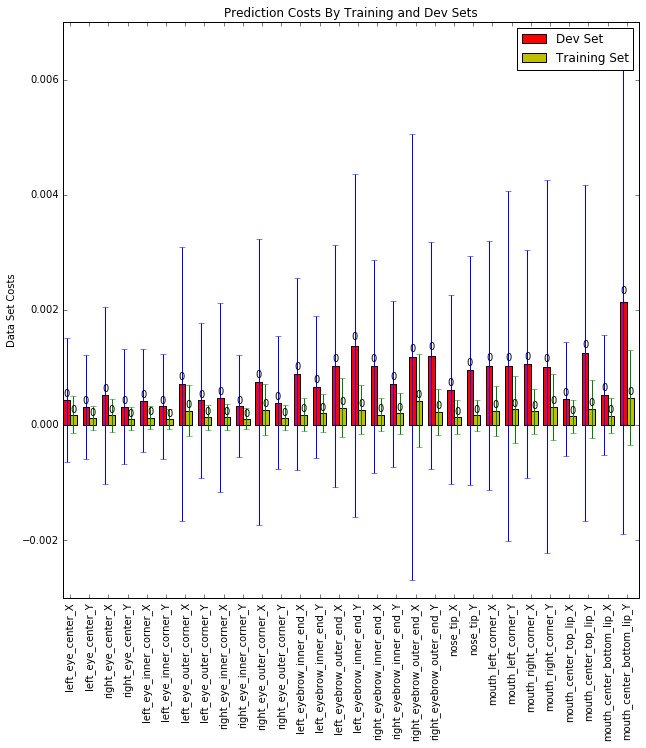

In [15]:
# On the mixed NN, which features are we learning best and which are we learning poorly?
# build a bar chart of the dev and training errors per feature.
feature_names = ['left_eye_center_X', 'left_eye_center_Y', 'right_eye_center_X', 'right_eye_center_Y', 
                'left_eye_inner_corner_X', 'left_eye_inner_corner_Y',
                'left_eye_outer_corner_X', 'left_eye_outer_corner_Y',  
                'right_eye_inner_corner_X', 'right_eye_inner_corner_Y',
                'right_eye_outer_corner_X', 'right_eye_outer_corner_Y', 
                'left_eyebrow_inner_end_X', 'left_eyebrow_inner_end_Y',
                'left_eyebrow_outer_end_X', 'left_eyebrow_inner_end_Y', 
                'right_eyebrow_inner_end_X', 'right_eyebrow_inner_end_Y', 
                'right_eyebrow_outer_end_X', 'right_eyebrow_outer_end_Y',
                'nose_tip_X', 'nose_tip_Y', 'mouth_left_corner_X', 'mouth_left_corner_Y',
                'mouth_right_corner_X', 'mouth_right_corner_Y',
                'mouth_center_top_lip_X', 'mouth_center_top_lip_Y',
                'mouth_center_bottom_lip_X', 'mouth_center_bottom_lip_Y']

feature_costs_de_means = ((deY - final_pdeY)**2).mean(axis=0)
print feature_costs_de_means.shape
print feature_costs_de_means
feature_costs_de_std = ((deY - final_pdeY)**2).std(axis=0)
feature_costs_tr_means = ((trY - final_ptrY)**2).mean(axis=0)
feature_costs_tr_std = ((trY - final_ptrY)**2).std(axis=0)

# the x locations for the groups
ind = np.arange(feature_costs_de_means.shape[0])
# the width of the bars
width = 0.35       

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

#fig, ax = fig.subplots()
ax = plt.subplot()
rects1 = ax.bar(ind, feature_costs_de_means, width, color='r', yerr=feature_costs_de_std)
ax = plt.subplot()
rects2 = ax.bar(ind + width, feature_costs_tr_means, width, color='y', yerr=feature_costs_tr_std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Data Set Costs')
ax.set_title('Prediction Costs By Training and Dev Sets')
ax.set_xticks(ind + width)
ax.set_xticklabels(feature_names, rotation=90)

ax.legend((rects1[0], rects2[0]), ('Dev Set', 'Training Set'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [16]:
# 
# Let's build functions to look into the convolution filters of all layers
#

# instantiate 4D tensor for input
input = T.tensor4(name='input')

output_1 = T.tanh( max_pool_2d(T.maximum(conv2d(input, w_1, border_mode='full'),0.), (2, 2),ignore_border=True) + b_1.dimshuffle('x', 0, 'x', 'x') )

output_2 = T.tanh( max_pool_2d(T.maximum(conv2d(output_1, w_2), 0.), (2, 2),ignore_border=True) + b_2.dimshuffle('x', 0, 'x', 'x') )

output_3 = T.tanh( max_pool_2d(T.maximum(conv2d(output_2, w_3), 0.), (2, 2),ignore_border=True) + b_3.dimshuffle('x', 0, 'x', 'x') )

# create theano function to compute filtered images
my_f1 = theano.function(inputs=[input], outputs=output_1, allow_input_downcast=True)
my_f2 = theano.function(inputs=[input], outputs=output_2, allow_input_downcast=True)
my_f3 = theano.function(inputs=[input], outputs=output_3, allow_input_downcast=True)


In [17]:
# Prepare an image
img_ = trX[highest_tr_indices[0]].reshape(-1, 1, 96, 96)
print 'Image shape: ', img_.shape

Image shape:  (1, 1, 96, 96)


('filtered image shape: ', (1, 32, 49, 49))


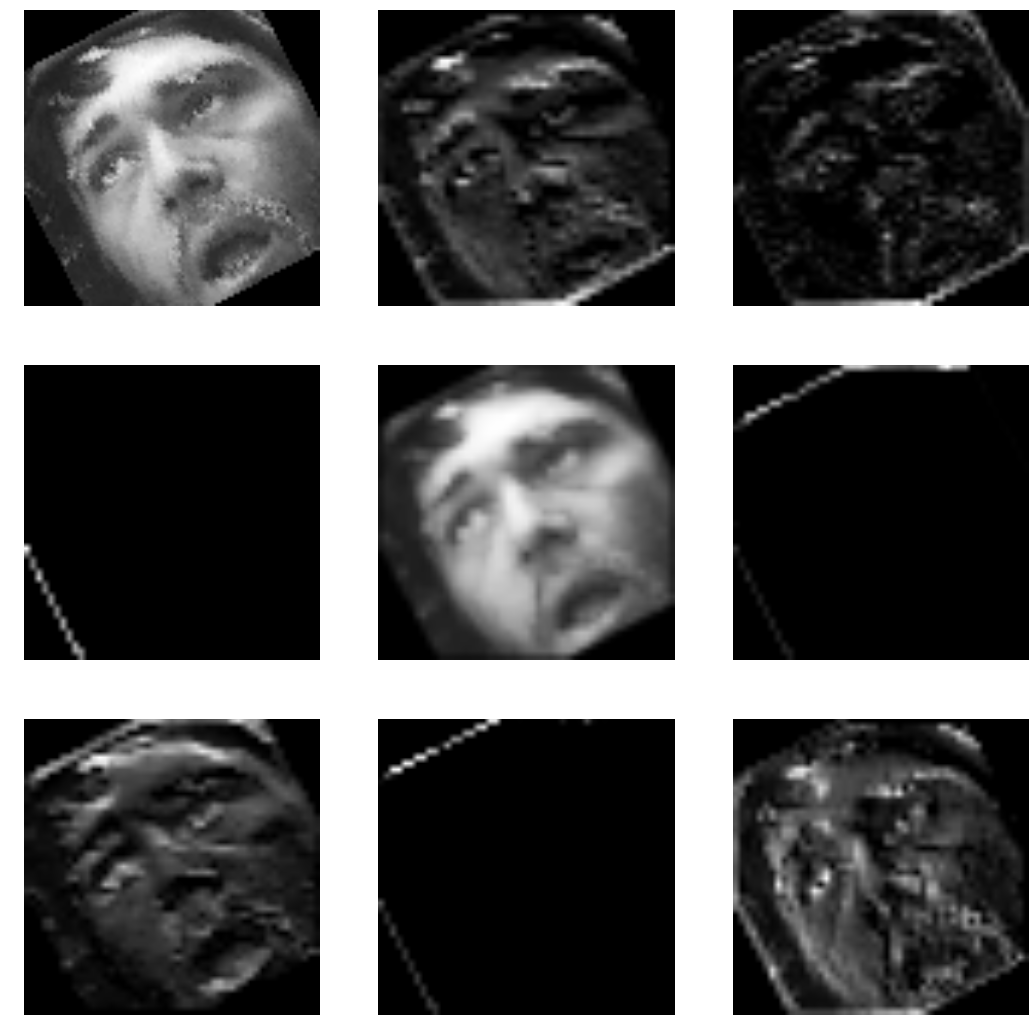

In [18]:
# Layer 1 output
filtered_img = my_f1(img_)
print("filtered image shape: ", filtered_img.shape)

pylab.figure(figsize=(18, 18))
# plot original image and first and second components of output
pylab.subplot(3, 3, 1); pylab.axis('off'); pylab.imshow(img_[0,0,:,:])
pylab.gray();

for i in range(0,8):
    pylab.subplot(3, 3, i+2); pylab.axis('off'); pylab.imshow(filtered_img[0, i, :, :])
pylab.show()

('filtered image shape: ', (1, 64, 23, 23))


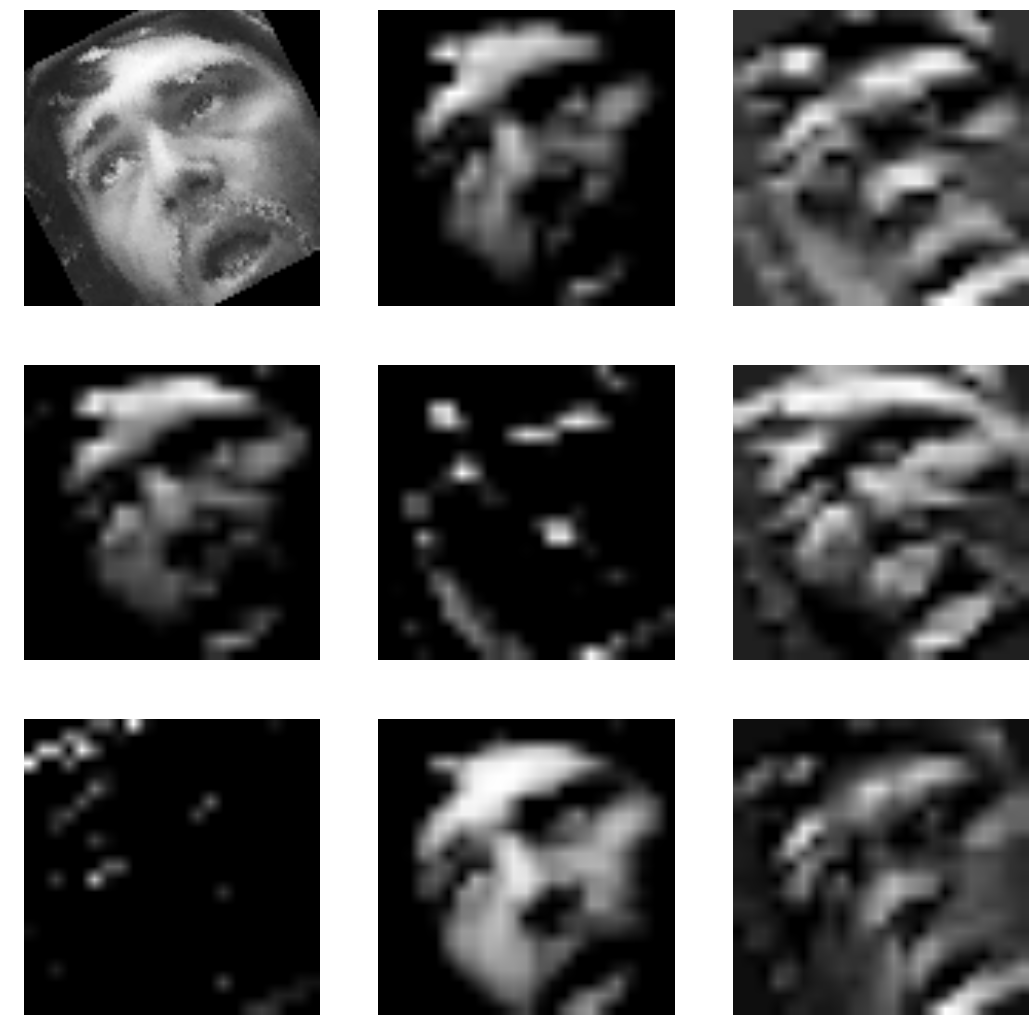

In [19]:
# Layer 2 output
filtered_img = my_f2(img_)
print("filtered image shape: ", filtered_img.shape)

pylab.figure(figsize=(18, 18))
# plot original image and first and second components of output
pylab.subplot(3, 3, 1); pylab.axis('off'); pylab.imshow(img_[0,0,:,:])
pylab.gray();

for i in range(0,8):
    pylab.subplot(3, 3, i+2); pylab.axis('off'); pylab.imshow(filtered_img[0, i, :, :])
pylab.show()

('filtered image shape: ', (1, 128, 10, 10))


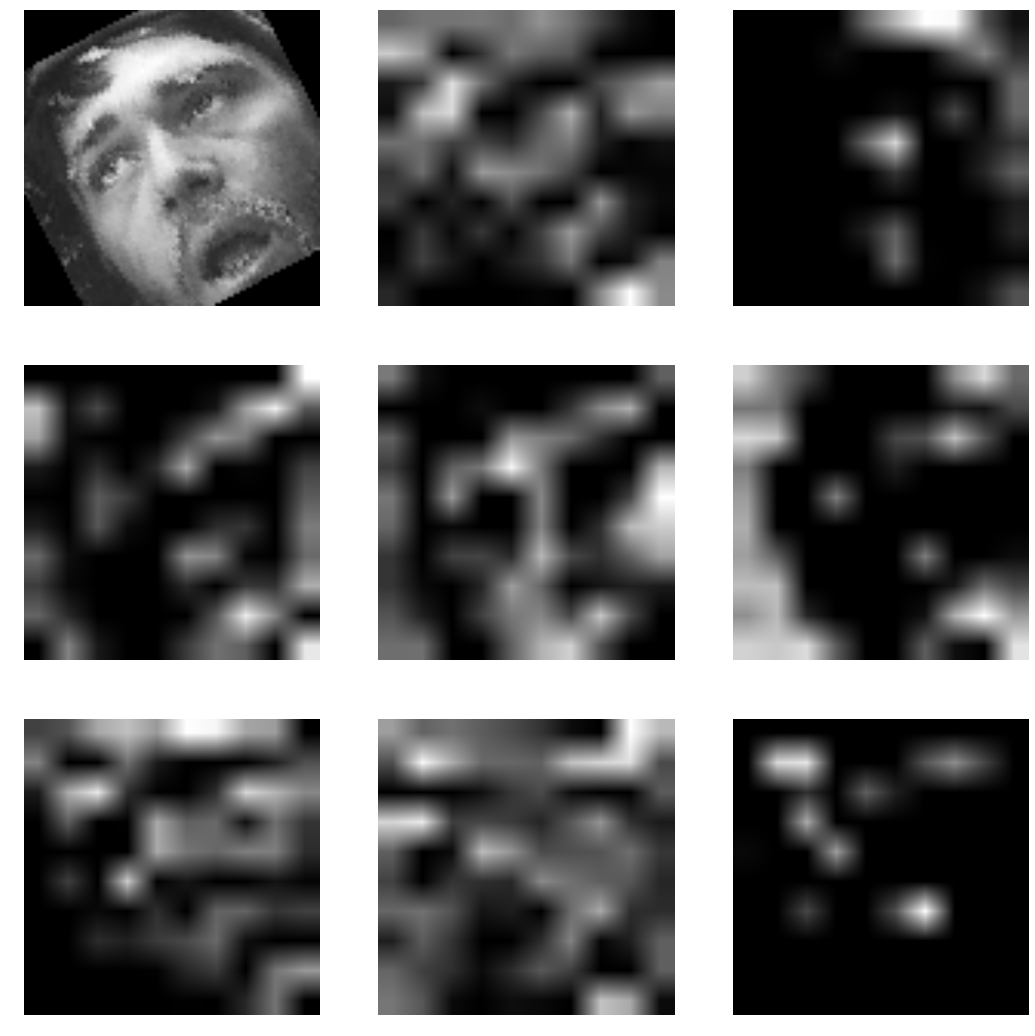

In [20]:
# Layer 3 output
filtered_img = my_f3(img_)
print("filtered image shape: ", filtered_img.shape)

pylab.figure(figsize=(18, 18))
# plot original image and first and second components of output
pylab.subplot(3, 3, 1); pylab.axis('off'); pylab.imshow(img_[0,0,:,:])
pylab.gray();

for i in range(0,8):
    pylab.subplot(3, 3, i+2); pylab.axis('off'); pylab.imshow(filtered_img[0, i, :, :])
pylab.show()

In [23]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

from PIL import Image
from PIL import ImageFilter
from math import cos, sin

FTRAIN = '../../Data/training.csv'
FTEST = '../../Data/test.csv'

def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        y = y.astype(np.float32) 
        X, y = shuffle(X, y, random_state=42)  # shuffle train data        

        print("X.shape == {0}; X.min == {1:.3f}; X.max == {2:.3f}".format(
            X.shape, X.min(), X.max()))
        print("y.shape == {0}; y.min == {1:.3f}; y.max == {2:.3f}".format(
            y.shape, y.min(), y.max()))    
    else:
        y = None

    
    return X, y

In [26]:
test_X, none_Y = load(test=True)
test_X = test_X.reshape(-1, 1, imageWidth, imageWidth)

# Compute convo layer predictions
convo_test_preds = predict(test_X)

# Storage for post_conv_predictions on the test set
test_post_predictions = np.zeros((test_X.shape[0],trY.shape[1]), dtype=theano.config.floatX)

# Compute the post convo-predictions
for i in range(0,30):
    # Predict feature i with the corresponding classifier
    post_convo_test_pred = post_NNs[i].predict(convo_test_preds)
    
    # Store prediction away
    test_post_predictions[:,[i]] = post_convo_test_pred
    
print test_post_predictions

ImageId    1783
Image      1783
dtype: int64
[[ 0.37013403 -0.2246325  -0.38278174 ...,  0.43522435 -0.00445552
   0.73750991]
 [ 0.41992164 -0.23823516 -0.4155747  ...,  0.50488091  0.0208198
   0.80080938]
 [ 0.38752472 -0.23459215 -0.34948096 ...,  0.48808378  0.05265315
   0.79057723]
 ..., 
 [ 0.38019633 -0.13072458 -0.31384376 ...,  0.59492314 -0.05119854
   0.62122387]
 [ 0.32474923 -0.20771189 -0.37293321 ...,  0.44742611 -0.03950027
   0.60407972]
 [ 0.40816152 -0.20742865 -0.35531574 ...,  0.59227383  0.01083347
   0.80033851]]


In [29]:
import pandas as pd

outputFile = '../Data/PostConvoSubmission.csv'
oFile = open(outputFile,'w')
subform = open('../Data/submissionFormat.csv')
subLines = subform.readlines()
colnames = [u'left_eye_center_x', u'left_eye_center_y', u'right_eye_center_x',
       u'right_eye_center_y', u'left_eye_inner_corner_x',
       u'left_eye_inner_corner_y', u'left_eye_outer_corner_x',
       u'left_eye_outer_corner_y', u'right_eye_inner_corner_x',
       u'right_eye_inner_corner_y', u'right_eye_outer_corner_x',
       u'right_eye_outer_corner_y', u'left_eyebrow_inner_end_x',
       u'left_eyebrow_inner_end_y', u'left_eyebrow_outer_end_x',
       u'left_eyebrow_outer_end_y', u'right_eyebrow_inner_end_x',
       u'right_eyebrow_inner_end_y', u'right_eyebrow_outer_end_x',
       u'right_eyebrow_outer_end_y', u'nose_tip_x', u'nose_tip_y',
       u'mouth_left_corner_x', u'mouth_left_corner_y', u'mouth_right_corner_x',
       u'mouth_right_corner_y', u'mouth_center_top_lip_x',
       u'mouth_center_top_lip_y', u'mouth_center_bottom_lip_x',
       u'mouth_center_bottom_lip_y']

pred_df = pd.DataFrame(test_post_predictions*48+48,columns=colnames)

header = subLines.pop(0)
header = 'rowId,Location'

lastLine = subLines.pop(-1)

oFile.write(header+'\n')
for ll in subLines:
    thisLine = ll.split(',')
    thisImageNum = int(thisLine[1])-1  # data are 1-indexed
    thisLabel = thisLine[2].strip()

    outLine = []
    outLine.append(str(thisLine[0]))
    thisLoc = pred_df[thisLabel][thisImageNum]
    
    if thisLoc > 96:
        print outLine,thisLoc
        thisLoc=96
        
    if thisLoc < 0:
        print outLine,thisLoc
        thisLoc = 0
      
    outLine.append(str('%.10f'%thisLoc))
    oFile.write(",".join(outLine)+'\n')
    #print ",".join(outLine)

oFile.close()
subform.close()
print 'Submission Generated.  File: ', outputFile

Submission Generated.  File:  ../Data/PostConvoSubmission.csv


In [55]:
post_convolution_tr_images = np.zeros((trX.shape[0], 128, 10, 10), dtype=theano.config.floatX)
for i in range(trX.shape[0]):
    filtered_img = my_f3(trX[i].reshape(-1, 1, 96, 96))
    post_convolution_tr_images[i] = filtered_img        

post_convolution_tr_images = post_convolution_tr_images.reshape(post_convolution_tr_images.shape[0]*128, 100)

post_convolution_de_images = np.zeros((deX.shape[0], 128, 10, 10), dtype=theano.config.floatX)
for i in range(deX.shape[0]):
    filtered_img = my_f3(deX[i].reshape(-1, 1, 96, 96))
    post_convolution_de_images[i] = filtered_img        

post_convolution_de_images = post_convolution_de_images.reshape(post_convolution_de_images.shape[0]*128, 100)

In [46]:
%matplotlib inline

import numpy as np
import matplotlib.colors as clrs
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm
import math
import collections

Explained variance ratio: 
[ 0.16408006  0.06663638  0.03893356  0.03647582  0.02862795  0.0277222
  0.02338617  0.02223438  0.02008236  0.01912377  0.01801822  0.01643206
  0.01588156  0.01452791  0.01395145  0.01379989  0.01286376  0.0123676
  0.01200411  0.01185903  0.01113248  0.01077948  0.01039149  0.0101044
  0.00942824  0.00930473  0.00910834  0.00900576  0.00892347  0.00868722
  0.00825077  0.00815383  0.00784869  0.00766425  0.00751381  0.00747715
  0.00730799  0.00719936  0.0069318   0.00675281  0.00654245  0.0064873
  0.00640045  0.00633385  0.00619233  0.00604241  0.00595014  0.00590523
  0.00576935  0.00574883  0.00561773  0.0055121   0.00541743  0.00535238
  0.00523683  0.0050483   0.00499311  0.00485507  0.00478448  0.00470448
  0.00462047  0.00457926  0.00455067  0.00439404  0.0043673   0.00430489
  0.0042181   0.00418097  0.00405661  0.00400704  0.00393776  0.00389334
  0.00382314  0.00377424  0.00370848  0.0036443   0.00352343  0.00343338
  0.00342672  0.00336851  0.

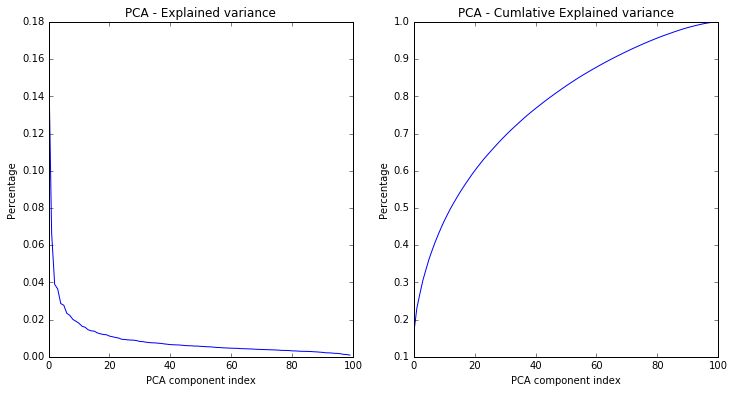

In [104]:
# Set the number of PCA components to 100
n_comp = 100
pca_mod = PCA(n_components = n_comp)
# Fit the data with PCA
pca_mod.fit(post_convolution_tr_images)

# Report explained variance per (covariance matrix) eigenvector and display cumulative explained variance
print 'Explained variance ratio: \n', pca_mod.explained_variance_ratio_ 
print 'Cumulative explained variance: \n', np.cumsum(pca_mod.explained_variance_ratio_)
# Display the PCA component vactors
print 'PCA components: \n', pca_mod.components_ 

# Plot the explained variance ratio
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(pca_mod.explained_variance_ratio_)
plt.title('PCA - Explained variance')
plt.xlabel('PCA component index')
plt.ylabel('Percentage')

# Plot the cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(pca_mod.explained_variance_ratio_))
plt.title('PCA - Cumlative Explained variance')
plt.xlabel('PCA component index')
plt.ylabel('Percentage')

In [105]:
pca_train_data = PCA(n_components = 50).fit(post_convolution_tr_images).transform(post_convolution_tr_images)
pca_dev_data = PCA(n_components = 50).fit(post_convolution_tr_images).transform(post_convolution_de_images)

pca_train_data_nn = pca_train_data.reshape(pca_train_data.shape[0]/128, 50*128)
pca_dev_data_nn = pca_dev_data.reshape(pca_dev_data.shape[0]/128, 50*128)

In [106]:
###############################################################################
# Two Hidden layer NN to process convo prediction output
###############################################################################
pca_num_inputs = 6400
pca_num_hidden = 500
pca_num_outputs = 1
pca_pdrop_input = .2
pca_pdrop_hidden = .2

class PCATwoHiddenLayerNN:
    def __init__(self, inputs, hidden, outputs, pdrop_input, pdrop_hidden, weight_initialization_index=None):
        self.num_inputs = inputs
        self.num_hidden = hidden
        self.num_outputs = outputs
        
        if weight_initialization_index is None:
            # By deafult initialize random weights
            self.w_h_1 = theano.shared(floatX(np.asarray((np.random.randn(*(self.num_inputs, self.num_hidden))*.01))))
            self.w_h_2 = theano.shared(floatX(np.asarray((np.random.randn(*(self.num_hidden, self.num_hidden))*.01))))
            self.w_o = theano.shared(floatX(np.asarray((np.random.randn(*(self.num_hidden, self.num_outputs))*.01))))
        else:
            # All weigths are zero except the input value we want to start gradient descent from
            w_h_1 = numpy.zeros((self.num_inputs, self.num_hidden), dtype=theano.config.floatX)
            w_h_1[weight_initialization_index,weight_initialization_index] = 1.0
            w_h_2 = numpy.zeros((self.num_hidden, self.num_hidden), dtype=theano.config.floatX)
            w_h_2[weight_initialization_index,weight_initialization_index] = 1.0
            w_o = numpy.zeros((self.num_hidden, self.num_outputs), dtype=theano.config.floatX)
            w_o[weight_initialization_index,0] = 1.0
            
            self.w_h_1 = theano.shared(value=w_h_1, borrow=True)
            self.w_h_2 = theano.shared(value=w_h_2, borrow=True)
            self.w_o = theano.shared(value=w_o, borrow=True)

        self.X = T.fmatrix("back_X")
        self.Y = T.fmatrix("back_Y")

        training_activation_layer2, self.training_prediction = self.model(pdrop_input, pdrop_hidden)
        pred_activation_layer2, self.actual_prediction = self.model(0., 0.)
        
        self.training_cost = ((self.Y - self.training_prediction)**2).mean()
        
        self.params = [self.w_h_1, self.w_h_2, self.w_o]
        self.updates = self.sgd()
        
        self.train = theano.function(inputs=[self.X, self.Y], outputs=self.training_cost, updates=self.updates, allow_input_downcast=True)
        self.predict = theano.function(inputs=[self.X], outputs=self.actual_prediction, allow_input_downcast=True)

    def train(self, X, Y):
        return self.train(X, Y)
    
    def predict(self, X):
        return self.predict(X)
    
    def backprop(self, alpha=0.001, rho=0.9, epsilon=1e-6):
        grads = T.grad(cost=self.training_cost, wrt=self.params)
        updates = []
        for w1, grad in zip(self.params, grads):

            # adding gradient scaling
            acc = theano.shared(w1.get_value() * 0.)
            acc_new = rho * acc + (1 - rho) * grad ** 2
            gradient_scaling = T.sqrt(acc_new + epsilon)
            grad = grad / gradient_scaling
            updates.append((acc, acc_new))

            updates.append((w1, w1 - grad * alpha))
        return updates


    def model(self, pdrop_input, pdrop_hidden):
        X = dropout(self.X, pdrop_input)

        h1 = T.maximum(T.dot(self.X, self.w_h_1), 0.)
        h1 = dropout(h1, pdrop_hidden)
        
        h2 = T.maximum(T.dot(h1, self.w_h_2), 0.)
        h2 = dropout(h2, pdrop_hidden)

        py_x = T.dot(h2, self.w_o)
        return h2, py_x

    def sgd(self, lr=0.001):
        grads = T.grad(cost=self.training_cost, wrt=self.params)
        updates = []
        for w1, grad in zip(self.params, grads):
            updates.append([w1, w1 - grad * lr])
        return updates
    
    def gradient_descent_stochastic(self, trX, trY, deX, deY, epochs, miniBatchSize=1):
        training_costs=[]
        dev_costs=[]
        trainTime = 0.0
        predictTime = 0.0
        start_time = time.time()
        for i in range(epochs):       
            for start, end in zip(range(0, len(trX), miniBatchSize), range(miniBatchSize, len(trX), miniBatchSize)):
                cost = self.train(trX[start:end], trY[start:end])

            # Compute overall dev and training costs after epoch
            pdeY = self.predict(deX)
            cost_de = ((deY - pdeY)**2).mean()

            ptrY = self.predict(trX)
            cost_tr = ((trY - ptrY)**2).mean()

            # Capture the traning and dev costs on each epoch
            training_costs.append(cost_tr)
            dev_costs.append(cost_de)

            trainTime =  trainTime + (time.time() - start_time)
   
        print 'Back Traning cost=%.8f, DE cost: %.8f' %(cost_tr, cost_de)

        print 'train time = %.2f' %(trainTime)

        return training_costs, dev_costs

In [109]:
de_pca_predictions = np.zeros((deY.shape[0],deY.shape[1]), dtype=theano.config.floatX)
tr_pca_predictions = np.zeros((trY.shape[0],trY.shape[1]), dtype=theano.config.floatX)
pca_NNs = []

for i in range(0,30):
    pca_nn = PCATwoHiddenLayerNN(pca_num_inputs, pca_num_hidden, pca_num_outputs, pca_pdrop_input, pca_pdrop_hidden)
    pca_nn.gradient_descent_stochastic(pca_train_data_nn, trY[:,[i]], pca_dev_data_nn, deY[:,[i]], 5000, miniBatchSize=128)

    pca_NNs.append(pca_nn)
    
    pred_deY = pca_nn.predict(pca_dev_data_nn)
    pred_trY = pca_nn.predict(pca_train_data_nn)
    
    de_pca_predictions[:,[i]] = pred_deY
    tr_pca_predictions[:,[i]] = pred_trY


print 'Mean Dev squared error on Post PCA Predictions: %.8f\n'%((deY - de_pca_predictions)**2).mean()
print 'Mean Training squared error on Post PCA Predictions: %.8f\n'%((trY - tr_pca_predictions)**2).mean()


Back Traning cost=0.00059930, DE cost: 0.00068908
train time = 1648296.59
Back Traning cost=0.00053176, DE cost: 0.00055335
train time = 1646967.70
Back Traning cost=0.00055884, DE cost: 0.00069445
train time = 1645817.87
Back Traning cost=0.00049516, DE cost: 0.00050466
train time = 1647470.13
Back Traning cost=0.00064902, DE cost: 0.00060346
train time = 1647802.37
Back Traning cost=0.00047980, DE cost: 0.00056399
train time = 1648231.00
Back Traning cost=0.00067369, DE cost: 0.00093763
train time = 1646903.40
Back Traning cost=0.00068541, DE cost: 0.00069551
train time = 1649834.79
Back Traning cost=0.00057025, DE cost: 0.00059341
train time = 1648629.86
Back Traning cost=0.00044321, DE cost: 0.00052116
train time = 1651303.61
Back Traning cost=0.00063232, DE cost: 0.00100580
train time = 1649077.78
Back Traning cost=0.00065381, DE cost: 0.00057040
train time = 1651508.70
Back Traning cost=0.00106763, DE cost: 0.00112317
train time = 1649838.10
Back Traning cost=0.00076472, DE cost:

In [110]:
post_convolution_test_images = np.zeros((test_X.shape[0], 128, 10, 10), dtype=theano.config.floatX)
for i in range(test_X.shape[0]):
    filtered_img = my_f3(test_X[i].reshape(-1, 1, 96, 96))
    post_convolution_test_images[i] = filtered_img        

post_convolution_test_images = post_convolution_test_images.reshape(post_convolution_test_images.shape[0]*128, 100)

pca_test_data = PCA(n_components = 50).fit(post_convolution_tr_images).transform(post_convolution_test_images)

pca_test_data_nn = pca_test_data.reshape(pca_test_data.shape[0]/128, 50*128)

In [111]:
# Storage for post_conv_predictions on the test set
test_pca_predictions = np.zeros((test_X.shape[0],trY.shape[1]), dtype=theano.config.floatX)

# Compute the pca-predictions
for i in range(0,30):
    # Predict feature i with the corresponding classifier
    pca_test_pred = pca_NNs[i].predict(pca_test_data_nn)
    
    # Store prediction away
    test_pca_predictions[:,[i]] = pca_test_pred
    
print test_pca_predictions

[[ 0.37513626 -0.2107795  -0.40232751 ...,  0.4131273  -0.01971053
   0.77006251]
 [ 0.40813881 -0.23387976 -0.39116824 ...,  0.49437213  0.04347514
   0.75348473]
 [ 0.34402248 -0.23501332 -0.35517547 ...,  0.48820618  0.02252527
   0.75261647]
 ..., 
 [ 0.38872269 -0.16628151 -0.33579263 ...,  0.56736875 -0.05392483
   0.6685977 ]
 [ 0.34453347 -0.23397289 -0.40941259 ...,  0.50731939 -0.03025619
   0.58449244]
 [ 0.37737173 -0.20085633 -0.36733472 ...,  0.55261517 -0.02085494
   0.7512694 ]]


In [112]:
import pandas as pd

outputFile = '../Data/PCASubmission.csv'
oFile = open(outputFile,'w')
subform = open('../Data/submissionFormat.csv')
subLines = subform.readlines()
colnames = [u'left_eye_center_x', u'left_eye_center_y', u'right_eye_center_x',
       u'right_eye_center_y', u'left_eye_inner_corner_x',
       u'left_eye_inner_corner_y', u'left_eye_outer_corner_x',
       u'left_eye_outer_corner_y', u'right_eye_inner_corner_x',
       u'right_eye_inner_corner_y', u'right_eye_outer_corner_x',
       u'right_eye_outer_corner_y', u'left_eyebrow_inner_end_x',
       u'left_eyebrow_inner_end_y', u'left_eyebrow_outer_end_x',
       u'left_eyebrow_outer_end_y', u'right_eyebrow_inner_end_x',
       u'right_eyebrow_inner_end_y', u'right_eyebrow_outer_end_x',
       u'right_eyebrow_outer_end_y', u'nose_tip_x', u'nose_tip_y',
       u'mouth_left_corner_x', u'mouth_left_corner_y', u'mouth_right_corner_x',
       u'mouth_right_corner_y', u'mouth_center_top_lip_x',
       u'mouth_center_top_lip_y', u'mouth_center_bottom_lip_x',
       u'mouth_center_bottom_lip_y']

pred_df = pd.DataFrame(test_pca_predictions*48+48,columns=colnames)

header = subLines.pop(0)
header = 'rowId,Location'

lastLine = subLines.pop(-1)

oFile.write(header+'\n')
for ll in subLines:
    thisLine = ll.split(',')
    thisImageNum = int(thisLine[1])-1  # data are 1-indexed
    thisLabel = thisLine[2].strip()

    outLine = []
    outLine.append(str(thisLine[0]))
    thisLoc = pred_df[thisLabel][thisImageNum]
    
    if thisLoc > 96:
        print outLine,thisLoc
        thisLoc=96
        
    if thisLoc < 0:
        print outLine,thisLoc
        thisLoc = 0
      
    outLine.append(str('%.10f'%thisLoc))
    oFile.write(",".join(outLine)+'\n')
    #print ",".join(outLine)

oFile.close()
subform.close()
print 'Submission Generated.  File: ', outputFile

Submission Generated.  File:  ../Data/PCASubmission.csv


In [114]:
#
# Post PCA NNs
#

de_post_pca_predictions = np.zeros((deY.shape[0],deY.shape[1]), dtype=theano.config.floatX)
tr_post_pca_predictions = np.zeros((trY.shape[0],trY.shape[1]), dtype=theano.config.floatX)
post_pca_NNs = []

for i in range(0,30):
    hiddenNN = TwoHiddenLayerNN(back_num_inputs, back_num_hidden, back_num_outputs, 
                                back_pdrop_input, back_pdrop_hidden, i)
    hiddenNN.gradient_descent_stochastic(tr_pca_predictions, trY[:,[i]], de_pca_predictions, deY[:,[i]], 100)
    post_pca_NNs.append(hiddenNN)
    
    pred_deY = hiddenNN.predict(de_pca_predictions)
    pred_trY = hiddenNN.predict(tr_pca_predictions)
    
    de_post_pca_predictions[:,[i]] = pred_deY
    tr_post_pca_predictions[:,[i]] = pred_trY

print 'Mean Dev squared error on Post PCA Predictions: %.8f\n'%((deY - de_post_pca_predictions)**2).mean()
print 'Mean Training squared error on Post Predictions: %.8f\n'%((trY - tr_post_pca_predictions)**2).mean()

print 'Mean squared error on Training data: %.8f\n'%((trY - trY.mean())**2).mean()
print 'Mean squared error on Dev data: %.8f\n'%((deY - deY.mean())**2).mean()

1) Back Traning cost=0.00058899, DE cost: 0.00068445
2) Back Traning cost=0.00058773, DE cost: 0.00068387
3) Back Traning cost=0.00058657, DE cost: 0.00068337
4) Back Traning cost=0.00058548, DE cost: 0.00068292
5) Back Traning cost=0.00058446, DE cost: 0.00068252
6) Back Traning cost=0.00058350, DE cost: 0.00068216
7) Back Traning cost=0.00058258, DE cost: 0.00068184
8) Back Traning cost=0.00058170, DE cost: 0.00068155
9) Back Traning cost=0.00058086, DE cost: 0.00068129
10) Back Traning cost=0.00058006, DE cost: 0.00068106
11) Back Traning cost=0.00057930, DE cost: 0.00068085
12) Back Traning cost=0.00057857, DE cost: 0.00068066
13) Back Traning cost=0.00057788, DE cost: 0.00068049
14) Back Traning cost=0.00057721, DE cost: 0.00068034
15) Back Traning cost=0.00057657, DE cost: 0.00068021
16) Back Traning cost=0.00057596, DE cost: 0.00068010
17) Back Traning cost=0.00057538, DE cost: 0.00067999
18) Back Traning cost=0.00057482, DE cost: 0.00067990
19) Back Traning cost=0.00057428, DE 

In [122]:
# Storage for post_conv_predictions on the test set
test_post_pca_predictions = np.zeros((test_X.shape[0],trY.shape[1]), dtype=theano.config.floatX)

# Compute the post convo-predictions
for i in range(0,30):
    # Predict feature i with the corresponding classifier
    post_pca_convo_test_pred = post_pca_NNs[i].predict(test_pca_predictions)
    
    # Store prediction away
    test_post_pca_predictions[:,[i]] = post_pca_convo_test_pred
    
print test_post_pca_predictions

[[ 0.37558091 -0.21562783 -0.41037694 ...,  0.41437796 -0.02410685
   0.77916586]
 [ 0.41568154 -0.2366395  -0.39728066 ...,  0.49539649  0.04855056
   0.76188695]
 [ 0.35048491 -0.23748866 -0.35780942 ...,  0.49237198  0.02842716
   0.76610482]
 ..., 
 [ 0.39557627 -0.16573822 -0.33880112 ...,  0.57459801 -0.04979695
   0.66991496]
 [ 0.34476447 -0.23511423 -0.41821906 ...,  0.51213419 -0.03996699
   0.57767409]
 [ 0.38568184 -0.19757678 -0.36973971 ...,  0.557594   -0.01909088
   0.75825137]]


In [123]:
import pandas as pd

outputFile = '../Data/PostPCASubmission.csv'
oFile = open(outputFile,'w')
subform = open('../Data/submissionFormat.csv')
subLines = subform.readlines()
colnames = [u'left_eye_center_x', u'left_eye_center_y', u'right_eye_center_x',
       u'right_eye_center_y', u'left_eye_inner_corner_x',
       u'left_eye_inner_corner_y', u'left_eye_outer_corner_x',
       u'left_eye_outer_corner_y', u'right_eye_inner_corner_x',
       u'right_eye_inner_corner_y', u'right_eye_outer_corner_x',
       u'right_eye_outer_corner_y', u'left_eyebrow_inner_end_x',
       u'left_eyebrow_inner_end_y', u'left_eyebrow_outer_end_x',
       u'left_eyebrow_outer_end_y', u'right_eyebrow_inner_end_x',
       u'right_eyebrow_inner_end_y', u'right_eyebrow_outer_end_x',
       u'right_eyebrow_outer_end_y', u'nose_tip_x', u'nose_tip_y',
       u'mouth_left_corner_x', u'mouth_left_corner_y', u'mouth_right_corner_x',
       u'mouth_right_corner_y', u'mouth_center_top_lip_x',
       u'mouth_center_top_lip_y', u'mouth_center_bottom_lip_x',
       u'mouth_center_bottom_lip_y']

pred_df = pd.DataFrame(test_post_pca_predictions*48+48,columns=colnames)

header = subLines.pop(0)
header = 'rowId,Location'

lastLine = subLines.pop(-1)

oFile.write(header+'\n')
for ll in subLines:
    thisLine = ll.split(',')
    thisImageNum = int(thisLine[1])-1  # data are 1-indexed
    thisLabel = thisLine[2].strip()

    outLine = []
    outLine.append(str(thisLine[0]))
    thisLoc = pred_df[thisLabel][thisImageNum]
    
    if thisLoc > 96:
        print outLine,thisLoc
        thisLoc=96
        
    if thisLoc < 0:
        print outLine,thisLoc
        thisLoc = 0
      
    outLine.append(str('%.10f'%thisLoc))
    oFile.write(",".join(outLine)+'\n')
    #print ",".join(outLine)

oFile.close()
subform.close()
print 'Submission Generated.  File: ', outputFile

Submission Generated.  File:  ../Data/PostPCASubmission.csv
